In [ ]:
import os

exp_lst = [
    "paws_x_mbert_fft_oob_none", 
    "paws_x_mbert_fft_ls_none", 
    "paws_x_mbert_fft_ts_none", 
    "paws_x_xlmr_fft_oob_none", 
    "paws_x_xlmr_fft_ls_none", 
    "paws_x_xlmr_fft_ts_none"
]

for exp in exp_lst:
    os.system(f"python test.py +exp=test/{exp} ++model.save_pred=True")

In [3]:
import torch
from torchmetrics.classification import Accuracy, MulticlassCalibrationError, BinaryCalibrationError

# parameters
device = "cpu"
exp_lst = [
    "paws_x_mbert_fft_oob_none", 
    "paws_x_mbert_fft_ls_none", 
    "paws_x_mbert_fft_ts_none", 
    "paws_x_xlmr_fft_oob_none", 
    "paws_x_xlmr_fft_ls_none", 
    "paws_x_xlmr_fft_ts_none"
]
lang_lst = ["de"]

def flatten_list(lst):
    return [item for sublist in lst for item in sublist]

data = {}
for exp in exp_lst:
    if "xnli" in exp:
        acc = Accuracy(task="multiclass", num_classes=3).to(device)
        ece = MulticlassCalibrationError(num_classes=3, n_bins=10, norm="l1").to(device)
    else:
        acc = Accuracy(task="binary")
        ece = BinaryCalibrationError(n_bins=10, norm="l1")
    data[exp] = {}
    for lang in lang_lst:
        data[exp][lang] = {}
        conf_lst = []
        label_lst = []
        max_prob_lst = []
        prob_lst = []
        for seed in range(5):
            all_pred = torch.load(f"results/pred/{exp}/seed_{seed}/pred_{lang}", map_location=device)
            for batch in all_pred:
                conf_lst.append(batch[0].max(dim=1).values.tolist())
                label_lst.append(batch[1].flatten().tolist())
                max_prob_lst.append(batch[0].argmax(dim=1).tolist())
                if "xnli" in exp:
                    prob_lst.append(batch[0])
                else:
                    prob_lst.append(batch[0][:, 1])
        conf_lst = flatten_list(conf_lst)
        label_lst = flatten_list(label_lst)
        max_prob_lst = flatten_list(max_prob_lst)
        if "xnli" in exp:
            ece_score = ece(torch.cat(prob_lst).view(-1, 3), torch.tensor(label_lst, device=device))
        else:
            ece_score = ece(torch.cat(prob_lst), torch.tensor(label_lst))
        data[exp][lang] = {
            "conf": conf_lst,
            "max_prob": max_prob_lst,
            "label": label_lst,
            "ece": ece_score
        }
        if "xnli" in exp:
            num_bin = 7
        else:
            num_bin = 5
        bin_acc = []
        bin_conf = []
        for bin in range(num_bin):
            bin_conf.append(torch.tensor([x for x in conf_lst if (x >= 0.3 + 0.1 * bin) & (x < 0.3 + 0.1 * (1 + bin))]).mean())
            idx = [i for i, x in enumerate(conf_lst) if (x >= 0.3 + 0.1 * bin) & (x < 0.3 + 0.1 * (1 + bin))]
            bin_max_prob = [max_prob_lst[i] for i in idx]
            bin_label = [label_lst[i] for i in idx]
            bin_acc.append(acc(torch.tensor(bin_max_prob), torch.tensor(bin_label)))
        data[exp][lang]["bin_acc"] = bin_acc
        data[exp][lang]["bin_conf"] = bin_conf
            

paws_x_mbert_fft_oob_none


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [16]:
all_pred = torch.load(f"results/pred/paws_x_mbert_fft_oob_none/seed_1/pred_es", map_location=device)
all_pred

[]

In [5]:
data[exp][lang]["ece"].item()

0.06251567602157593

In [82]:
l = []
for batch in all_pred:
    l.append(batch[0])
torch.cat(l).view(-1, 3)

tensor([[0.0242, 0.9183, 0.0574],
        [0.0050, 0.5159, 0.4791],
        [0.0608, 0.7024, 0.2368],
        ...,
        [0.0695, 0.8018, 0.1286],
        [0.7371, 0.0748, 0.1881],
        [0.0358, 0.7164, 0.2478]], device='cuda:2')

TypeError: can't convert cuda:2 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

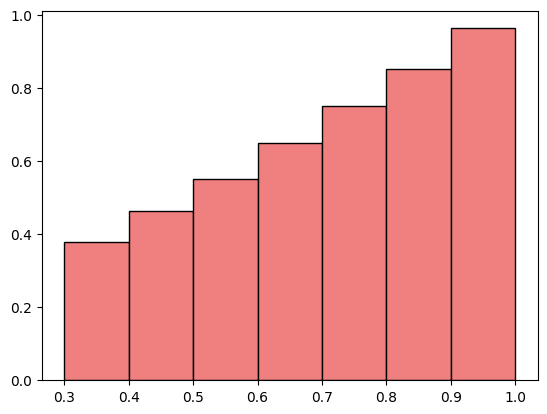

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
conf_val = data["xnli_xlmr_fft_oob_none"]["vi"]["bin_conf"]
acc_val = data["xnli_xlmr_fft_oob_none"]["vi"]["bin_acc"]

# Bar settings
bar_width = 0.1
positions = np.arange(0.35, 1.0, 0.1)

# Plotting
fig, ax = plt.subplots()

ax.bar(positions, conf_val, width=bar_width, color="lightcoral", edgecolor="black", align='center', label="Gap")
ax.bar(positions, acc_val, width=bar_width, color="royalblue", edgecolor="black", align='center', label="Outputs")
ax.plot([0, 1.0], [0, 1.0], 'r--', label='_nolegend_')
plt.text(0.875, 0.1, f"MCE = {data[exp][lang]["ece"].item():.2f} %", ha='center', va='center', fontsize=12, color='black',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
# Adjusting the x-axis to fit the bar groups
plt.xlim(0.3, 1.0)
plt.ylim(0.0, 1.0)

# Labels and title (optional)
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.legend()

plt.show()